# Assignment 3

As before, if a question can be answered with 'yes/no', or a numeric value, you may simply state as much. If you incorporate code from the internet (which is not required and generally not advisable), please cite the source within your code (providing a URL is sufficient).

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that no outside searches are required by the assignment!). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

In [60]:

# Load our previous libraries and objects
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split

# Import new libraries and objects
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.base import clone
from ISLP.models import sklearn_sm

### Question 1: Resampling via Bootstrapping

Now, we'll use the `iris` dataset, which we will add to Python using the `statsmodels` library. As always, start by reviewing a description of the dataset, by printing the dataset.

In [61]:
# Import
iris = sm.datasets.get_rdataset('iris', 'datasets')
df = pd.DataFrame(iris.data)
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


_(i)_ Create an `alpha_func(D, idx)` function which takes the `Sepal`'s `width` and `length` to calculate for alpha

In [62]:
def alpha_func(D, idx):
    cov_matrix = np.cov(D[['Sepal.Length', 'Sepal.Width']].loc[idx], rowvar=False)
    numerator = cov_matrix[1, 1] - cov_matrix[0, 1]
    denominator = cov_matrix[0, 0] + cov_matrix[1, 1] - 2 * cov_matrix[0, 1]
    alpha = numerator / denominator
    return alpha


Test the code below

In [63]:
alpha_func(df, range(100))

0.38105014898343803

_(ii)_ Construct a new bootstrap data set and recompute alpha

In [64]:
rng = np.random.default_rng(0)
alpha_func(df,
           rng.choice(100,
                      100,
                      replace=True))

0.3324645134841774

Imagine we are analysts working for a shipping company. The company wants to know the average length of iris' petals, to inform space allotment on an upcoming shipment. The relevant variable in the dataset is `Sepal.Length`. 

_(iii)_ Why is it (perhaps) not sufficient to simply calculate the mean of `Sepal.Length`? What more information will preforming a bootstrap provide to us?  

The sample mean can change every time the analysis is done. We also need to understand the variation or spead of the distribution. This will provide the uncertainty of the mean of the sample. 

_(iv)_ We can perform bootstrapping in Python by defining a simple function using `boot_SE()` for computing the bootstrap standard error. Remember, because bootstrapping involves randomness, we must first set a seed for reproducibility!

In [72]:
import warnings



def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    
    warnings.filterwarnings(action='ignore', category=FutureWarning, module='ISLP.models.columns', lineno=151)
    
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

_(v)_ Evaluate the accuracy of our alpha estimate with B = 1000

In [73]:
alpha_SE = boot_SE(alpha_func,
                   df,
                   B=1000,
                   seed=0)
alpha_SE

0.031805100768609415

_(vi)_ What is the original mean value of `Sepal.Length`?

In [74]:
original_mean_sepal_length = df['Sepal.Length'].mean()
original_mean_sepal_length


5.843333333333334

Next, let's create a new bootstrapping to bootstrap samples (`boot_se_samples`) of `Sepal.Length`, in order to compute its bootstrapped mean and standard deviation.

_(vii)_. Write code to review the bootstrapped mean value, and the standard deviation of the bootstrapped samples. Compare the mean against its original value. Then, review the bootstrapped range, by using `t_range = np.ptp(boot_se_samples)`.

In [69]:

# Bootstrap function to estimate the standard error of alpha
def boot_SE(data, statistic, *args, n_bootstrap=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    n = len(data)
    bootstrap_statistics = []
    
    for _ in range(n_bootstrap):
        bootstrap_sample_indices = np.random.choice(data, size=n, replace=True)
        bootstrap_statistic = statistic(*args, idx=bootstrap_sample_indices)
        bootstrap_statistics.append(bootstrap_statistic)
    
    return bootstrap_statistics

# Bootstrap samples
boot_se_samples = boot_SE(df.index, alpha_func, df, n_bootstrap=1000, seed=0)

# Bootstrapped mean value
boot_mean = np.mean(boot_se_samples)
print("Bootstrapped Mean:", boot_mean)

# Bootstrapped standard deviation
boot_std = np.std(boot_se_samples)
print("Bootstrapped Standard Deviation:", boot_std)

# Original mean value of Sepal.Length
original_mean_sepal_length = df['Sepal.Length'].mean()
print("Original Mean Sepal Length:", original_mean_sepal_length)

# Range of bootstrapped samples
t_range = np.ptp(boot_se_samples)
print("Range of Bootstrapped Samples:", t_range)


Bootstrapped Mean: 0.2403360375788221
Bootstrapped Standard Deviation: 0.031247810533374772
Original Mean Sepal Length: 5.843333333333334
Range of Bootstrapped Samples: 0.21103063368314962


_(viii)_ Next, let's compute 95% confidence intervals, for the mean value of iris sepal length. (Hint: use the `np.percentile` function)

In [70]:
# Compute 95% confidence interval
confidence_interval = np.percentile(boot_se_samples, [2.5, 97.5])
print("95% Confidence Interval for Mean Sepal Length:", confidence_interval)


95% Confidence Interval for Mean Sepal Length: [0.17664769 0.30166148]


_(ix)_. Use the plot function to create an histogram of the bootstrapped samples. What does this histogram show ?

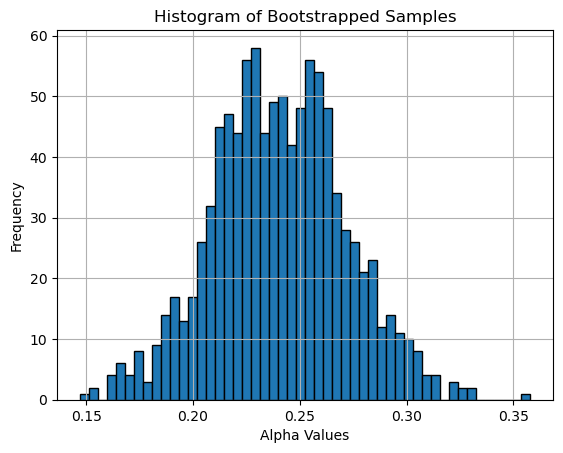

In [77]:
import matplotlib.pyplot as plt

# Plot histogram of bootstrapped samples
plt.hist(boot_se_samples, bins=50, edgecolor='black')
plt.title('Histogram of Bootstrapped Samples')
plt.xlabel('Alpha Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


_(x)_ Given your bootstrapped analysis, what do you recommend to shipping company? 

This shows a bimodal distribution. A bimodal distribution can be an important indicator of the underlying structure of your data. For example, it might suggest that your data contains two different groups of irises with different average petal lengths. This could be important information for your shipping company when planning space allotment

In [ ]:
# Write your answer here

# Criteria

|Criteria            |Complete           |Incomplete          |
|--------------------|---------------|--------------|
|Bootstrapping|All steps are done correctly and the answers are correct.|At least one step is done incorrectly leading to a wrong answer.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.


### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/applying_statistical_concepts/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
